<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cuda
--- Generating Data ---
Training Data Size: 20000

--- Phase 0: Warm-up Start (Data Only) ---
Goal: Data Loss should go down to ~1e-5 or 1e-6
[Warm-up] Ep 0 | Data Loss: 0.156797
[Warm-up] Ep 200 | Data Loss: 0.058244
[Warm-up] Ep 400 | Data Loss: 0.008536
[Warm-up] Ep 600 | Data Loss: 0.003293
[Warm-up] Ep 800 | Data Loss: 0.000681
[Warm-up] Ep 1000 | Data Loss: 0.000258
[Warm-up] Ep 1200 | Data Loss: 0.000143
[Warm-up] Ep 1400 | Data Loss: 0.000092
[Warm-up] Ep 1600 | Data Loss: 0.000065
[Warm-up] Ep 1800 | Data Loss: 0.000049
[Warm-up] Ep 2000 | Data Loss: 0.000037
[Warm-up] Ep 2200 | Data Loss: 0.000030
[Warm-up] Ep 2400 | Data Loss: 0.000024
[Warm-up] Ep 2600 | Data Loss: 0.000020
[Warm-up] Ep 2800 | Data Loss: 0.000016
[Warm-up] Ep 3000 | Data Loss: 0.000014
[Warm-up] Ep 3200 | Data Loss: 0.000012
[Warm-up] Ep 3400 | Data Loss: 0.000010
[Warm-up] Ep 3600 | Data Loss: 0.000009
[Warm-up] Ep 3800 | Data Loss: 0.000008
[Warm-up] Ep 4000 | Data Loss: 0.000007
[Warm-up] Ep

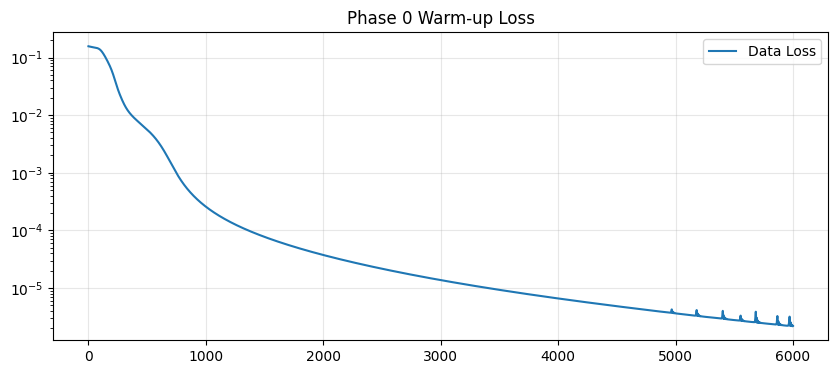

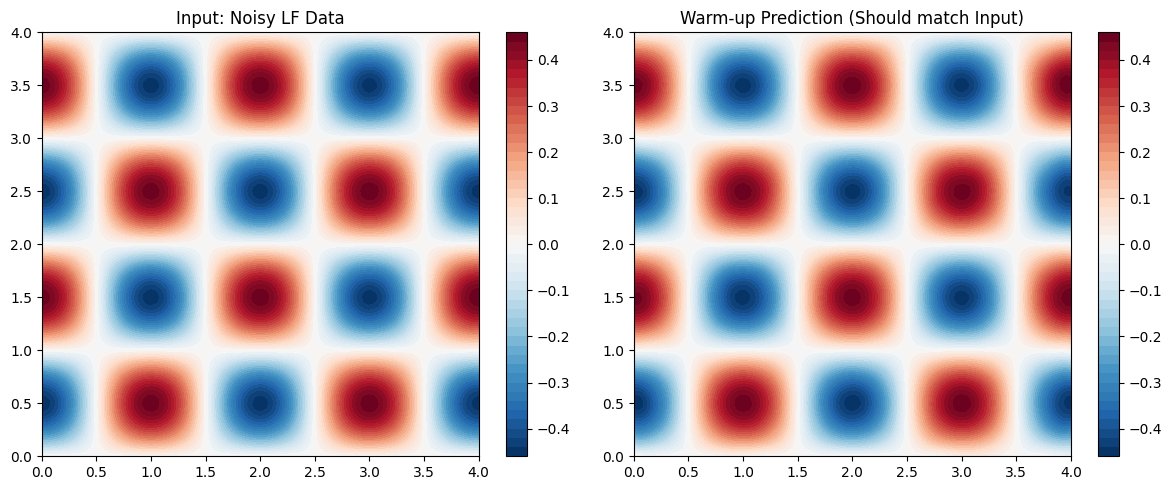

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 0. 환경 설정
# ==========================================
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

np.random.seed(42)
torch.manual_seed(42)

# ==========================================
# 1. 데이터 생성 클래스 (FluidGenerator)
# ==========================================
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.01):
        self.L = L
        self.nu = nu

    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = np.exp(-2 * (k * np.pi)**2 * self.nu * t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p_decay = np.exp(-4 * (k * np.pi)**2 * self.nu * t)
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * p_decay
        return u, v, p

    def get_stagnation_point_noise(self, X, Y, t):
        A = 0.05
        decay_rate = 1.0
        time_factor = np.exp(-decay_rate * t)
        xc, yc = 2.0, 2.0
        u =  A * (X - xc) * time_factor
        v = -A * (Y - yc) * time_factor
        term1 = 0.5 * A * (decay_rate + A * time_factor) * (X - xc)**2
        term2 = 0.5 * A * (decay_rate - A * time_factor) * (Y - yc)**2
        p = (term1 + term2) * time_factor
        return u, v, p

    def get_data_at_t(self, nx, ny, t_val):
        x = np.linspace(0, self.L, nx)
        y = np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_noise, v_noise, p_noise = self.get_stagnation_point_noise(X, Y, t_val)

        # LF Data (Input) = HF + Noise
        u_lf = u_hf + u_noise
        v_lf = v_hf + v_noise
        p_lf = p_hf + p_noise
        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# ==========================================
# 2. 데이터셋 구성
# ==========================================
L_val = 4.0
nu_val = 0.01
GRID = 100
generator = FluidGenerator(L=L_val, nu=nu_val)

train_times = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

x_list, y_list, t_list = [], [], []
u_train_list, v_train_list, p_train_list = [], [], []

print("--- Generating Data ---")
for t in train_times:
    X, Y, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, t)
    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))
    u_train_list.append(u_l.flatten())
    v_train_list.append(v_l.flatten())
    p_train_list.append(p_l.flatten())

# Numpy 병합
x_full = np.concatenate(x_list)/L_val
y_full = np.concatenate(y_list)/L_val
t_full = np.concatenate(t_list)
u_full = np.concatenate(u_train_list)
v_full = np.concatenate(v_train_list)
p_full = np.concatenate(p_train_list)

# 데이터 서브샘플링 (20,000개)
N_train = 20000
idx = np.random.choice(len(x_full), N_train, replace=False)

x_train = torch.tensor(x_full[idx], dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(y_full[idx], dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(t_full[idx], dtype=torch.float32).view(-1, 1).to(device)

u_train_lf = torch.tensor(u_full[idx], dtype=torch.float32).view(-1, 1).to(device)
v_train_lf = torch.tensor(v_full[idx], dtype=torch.float32).view(-1, 1).to(device)
p_train_lf = torch.tensor(p_full[idx], dtype=torch.float32).view(-1, 1).to(device)

print(f"Training Data Size: {N_train}")

# ==========================================
# 3. 모델 정의 (Fourier Scale=3.0)
# ==========================================
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=3.0): # Scale 3.0 설정
        super().__init__()
        self.register_buffer("B", torch.randn(in_channels, 256) * scale)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3)
        self.net = nn.Sequential(
            nn.Linear(512, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x, y, t):
        cat_input = torch.cat([x, y, t], dim=1)
        emb = self.embedding(cat_input)
        return self.net(emb)

# ==========================================
# 4. Phase 0 학습 (Warm-up)
# ==========================================
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

print("\n--- Phase 0: Warm-up Start (Data Only) ---")
print("Goal: Data Loss should go down to ~1e-5 or 1e-6")

loss_history = []
epochs = 6001

for epoch in range(epochs):
    optimizer.zero_grad()

    out_pred = model(x_train, y_train, t_train)
    u_pred, v_pred, p_pred = out_pred[:,0:1], out_pred[:,1:2], out_pred[:,2:3]

    # 순수 Data Loss (물리 Loss 없음)
    loss = torch.mean((u_pred - u_train_lf)**2 + (v_pred - v_train_lf)**2 + (p_pred - p_train_lf)**2)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"[Warm-up] Ep {epoch} | Data Loss: {loss.item():.6f}")

# 모델 저장
torch.save(model.state_dict(), "warmup_model.pth")
print("\n[Complete] Model saved as 'warmup_model.pth'")

# ==========================================
# 5. 검증 시각화
# ==========================================
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label='Data Loss')
plt.yscale('log')
plt.title('Phase 0 Warm-up Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 예측 확인 (Input과 비슷해야 성공)
test_t = 4
X_g, Y_g, u_lf_t, _, _, _, _, _ = generator.get_data_at_t(GRID, GRID, test_t)
x_t = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_t = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_t = torch.tensor(np.full(x_t.shape, test_t), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_t, y_t, t_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

fig = plt.figure(figsize=(12, 5))

# --- 첫 번째 그래프 (왼쪽) ---
plt.subplot(1, 2, 1)
# 팁: contourf 결과를 변수(cf)에 저장해두면 colorbar 그릴 때 명시하기 좋습니다.
cf1 = plt.contourf(X_g, Y_g, u_lf_t, levels=50, cmap='RdBu_r')
plt.title(f"Input: Noisy LF Data")
plt.colorbar(cf1) # 첫 번째 그래프에 대한 컬러바

# --- 두 번째 그래프 (오른쪽) ---
# *중요: 여기서 plt.figure()를 다시 호출하지 않습니다!*
plt.subplot(1, 2, 2)
cf2 = plt.contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r')
plt.title(f"Warm-up Prediction (Should match Input)")
plt.colorbar(cf2) # 두 번째 그래프에도 컬러바를 넣어주어야 크기 균형이 맞습니다.

# 레이아웃을 자동으로 조절하여 겹침 방지
plt.tight_layout()
plt.show()

Device: cuda
[Success] Warm-up Model Loaded.

--- Phase 1: Dynamic Physics Injection (Safety Net) ---
Strategy: If Data Loss spikes > 0.01, turn off Physics to recover.
[Phase 1] Ep 0
<Total loss: 5230.11523 | Scale=10.0>
Data Loss=0.00000 | Mass loss: 488.77243 | Momentum loss: 4741.34277
Data Weight: D=1.0 | Mass Weight: D=1.0 | Momentum Weight: D=1.0
[Phase 1] Ep 100
<Total loss: 0.19219 | Scale=0.1>
Data Loss=0.05034 | Mass loss: 0.00409 | Momentum loss: 0.02722
Data Weight: D=1.0 | Mass Weight: D=1.4 | Momentum Weight: D=5.0
[Phase 1] Ep 200
<Total loss: 0.34519 | Scale=0.1>
Data Loss=0.06732 | Mass loss: 0.00215 | Momentum loss: 0.00468
Data Weight: D=5.0 | Mass Weight: D=1.0 | Momentum Weight: D=1.4
[Phase 1] Ep 300
<Total loss: 0.06645 | Scale=0.1>
Data Loss=0.05139 | Mass loss: 0.00111 | Momentum loss: 0.00259
Data Weight: D=1.0 | Mass Weight: D=1.9 | Momentum Weight: D=5.0
[Phase 1] Ep 400
<Total loss: 0.25846 | Scale=0.1>
Data Loss=0.05050 | Mass loss: 0.00097 | Momentum los

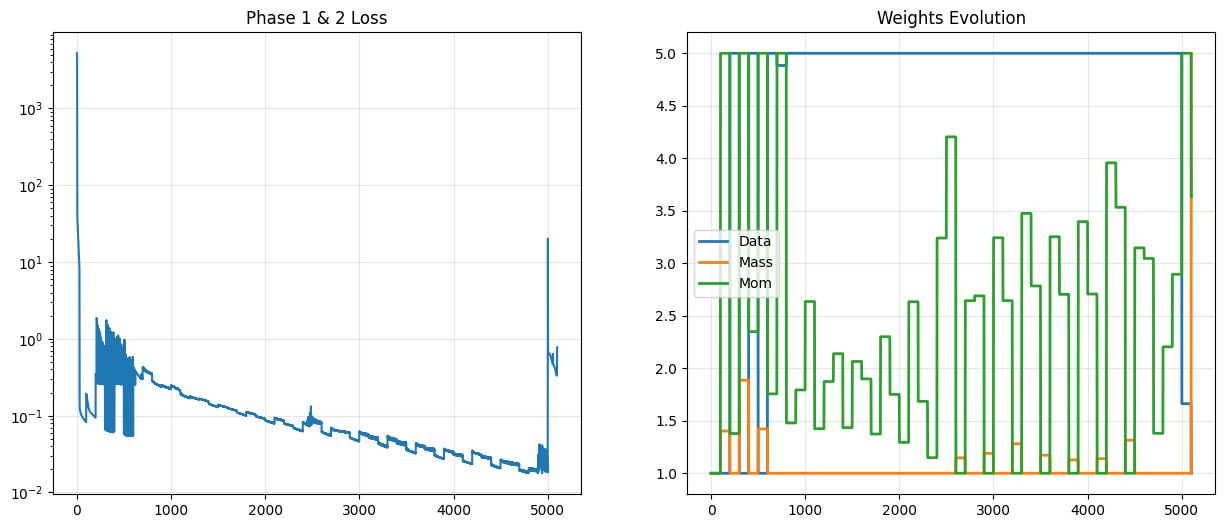

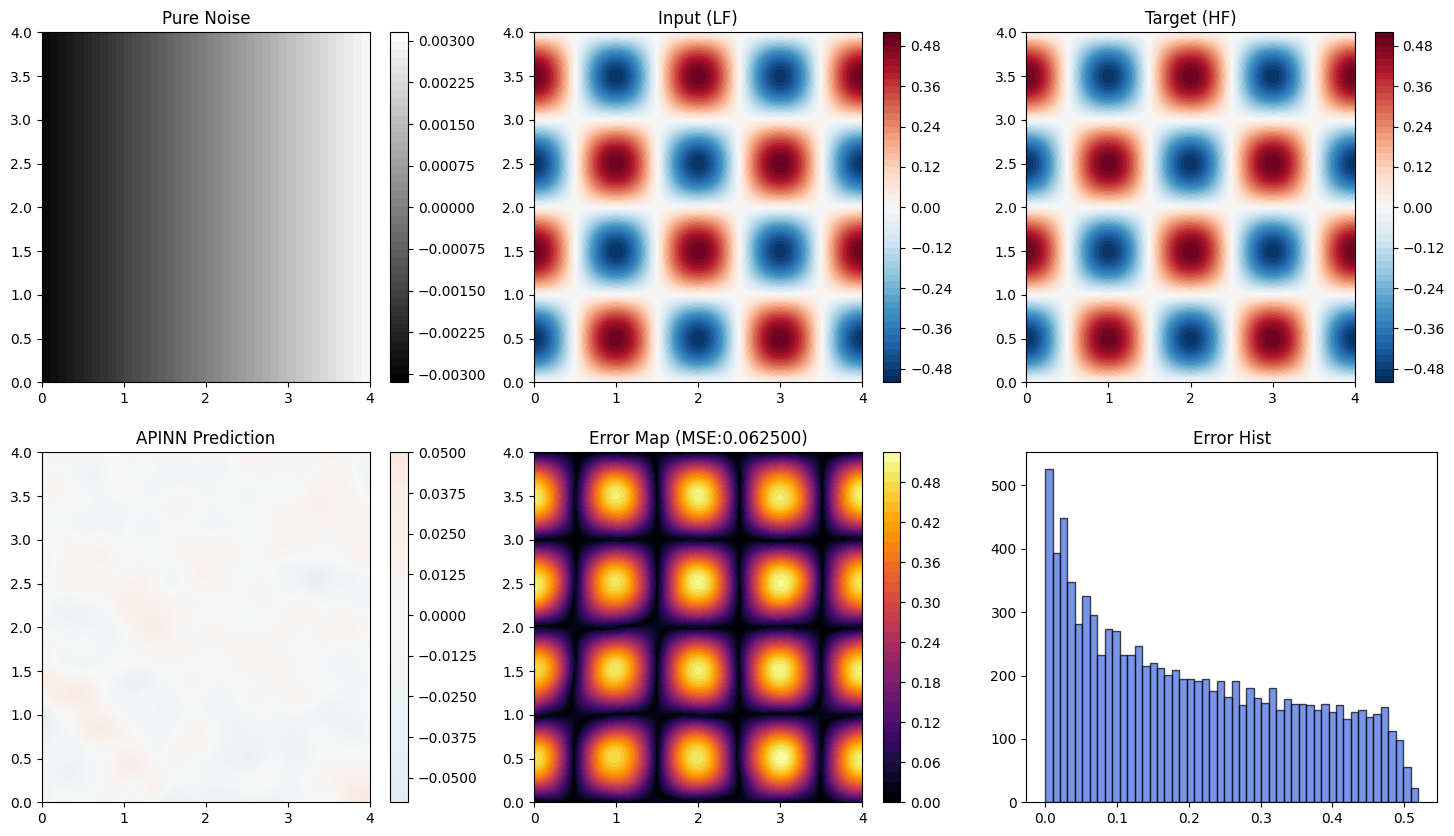

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# ==========================================
# 0. 환경 설정
# ==========================================
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

np.random.seed(42)
torch.manual_seed(42)

# ==========================================
# 1. 클래스 정의
# ==========================================
class APINN_WeightUpdater:
    # [설정] alpha=4.0
    def __init__(self, n_tasks=3, alpha=4.0, update_interval=100):
        self.n_tasks = n_tasks
        self.alpha = alpha
        self.N = update_interval
        self.loss_history = [[] for _ in range(n_tasks)]
        self.weights = torch.ones(n_tasks, device=device)
        self.weight_history = []
        self.iter_count = 0

    def update(self, current_losses):
        self.iter_count += 1
        for i, l in enumerate(current_losses):
            self.loss_history[i].append(l.item())
        self.weight_history.append(self.weights.cpu().numpy().copy())

        if self.iter_count % self.N == 0:
            V_bar = np.array([np.mean(h[-self.N:]) for h in self.loss_history])
            V_max, V_min = np.max(V_bar), np.min(V_bar)
            ratio = V_max / (V_min + 1e-10)

            if ratio > 1.0:
                R = (V_bar - V_min) / (V_max - V_min + 1e-10)
                new_weights = []
                for i in range(self.n_tasks):
                    if V_bar[i] == V_min: new_weights.append(1.0)
                    else: new_weights.append(1.0 + self.alpha * R[i])
                self.weights = torch.tensor(new_weights, dtype=torch.float32, device=device)

    def get_weights(self): return self.weights

class FluidGenerator:
    def __init__(self, L=4.0, nu=0.01):
        self.L, self.nu = L, nu
    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = np.exp(-2 * (k * np.pi)**2 * self.nu * t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * np.exp(-4 * (k * np.pi)**2 * self.nu * t)
        return u, v, p
    def get_stagnation_point_noise(self, X, Y, t):
        A, decay_rate = 0.05, 1.0
        time_factor = np.exp(-decay_rate * t)
        xc, yc = 2.0, 2.0
        u, v = A * (X - xc) * time_factor, -A * (Y - yc) * time_factor
        p = (0.5 * A * (decay_rate + A * time_factor) * (X - xc)**2 + 0.5 * A * (decay_rate - A * time_factor) * (Y - yc)**2) * time_factor
        return u, v, p
    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_stagnation_point_noise(X, Y, t_val)
        return X, Y, u_hf+u_n, v_hf+v_n, p_hf+p_n, u_hf, v_hf, p_hf

class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=3.0):
        super().__init__()
        self.register_buffer("B", torch.randn(in_channels, 256) * scale)
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3)
        self.net = nn.Sequential(
            nn.Linear(512, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3)
        )
    def forward(self, x, y, t):
        return self.net(self.embedding(torch.cat([x, y, t], dim=1)))

def get_pde_loss(model, x, y, t, nu, scale=1.0):
    out = model(x, y, t)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]

    v_t = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, torch.ones_like(v_y), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True)[0]

    # [수정됨] Moderate Scale = 10.0
    # 물리 Loss를 Data Loss보다 '적당히' 크게 만들어서 균형을 맞춤
    f_mass = (u_x + v_y) * scale
    f_u = (u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)) * scale
    f_v = (v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)) * scale

    loss_mass = torch.mean(f_mass**2)
    loss_momentum = torch.mean(f_u**2) + torch.mean(f_v**2)
    return loss_mass, loss_momentum

# ==========================================
# 2. 데이터셋 재구성
# ==========================================
L_val, nu_val, GRID = 4.0, 0.01, 100
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

x_list, y_list, t_list, u_train_list, v_train_list, p_train_list = [], [], [], [], [], []
for t in train_times:
    X, Y, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, t)
    x_list.append(X.flatten()); y_list.append(Y.flatten()); t_list.append(np.full(X.size, t))
    u_train_list.append(u_l.flatten()); v_train_list.append(v_l.flatten()); p_train_list.append(p_l.flatten())

x_full = np.concatenate(x_list)/L_val
y_full = np.concatenate(y_list)/L_val
t_full = np.concatenate(t_list)
u_full = np.concatenate(u_train_list)
v_full = np.concatenate(v_train_list)
p_full = np.concatenate(p_train_list)

N_train = 20000
idx = np.random.choice(len(x_full), N_train, replace=False)
x_train = torch.tensor(x_full[idx], dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(y_full[idx], dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(t_full[idx], dtype=torch.float32).view(-1, 1).to(device)
u_train_lf = torch.tensor(u_full[idx], dtype=torch.float32).view(-1, 1).to(device)
v_train_lf = torch.tensor(v_full[idx], dtype=torch.float32).view(-1, 1).to(device)
p_train_lf = torch.tensor(p_full[idx], dtype=torch.float32).view(-1, 1).to(device)

N_phys = 20000
x_phys = torch.rand(N_phys, 1, device=device).requires_grad_(True)
y_phys = torch.rand(N_phys, 1, device=device).requires_grad_(True)
t_phys = (torch.rand(N_phys, 1, device=device) * 10).requires_grad_(True)

# ==========================================
# 3. Phase 1: Physics Injection with Safety Net
# ==========================================
model = PINN().to(device)
try:
    model.load_state_dict(torch.load("warmup_model.pth"))
    print("[Success] Warm-up Model Loaded.")
except FileNotFoundError:
    print("[Error] Phase 0 First.")
    exit()

# Optimizer 리셋 (Low LR)
optimizer_apinn = optim.Adam(model.parameters(), lr=1e-4)
weight_updater = APINN_WeightUpdater(n_tasks=3, alpha=4.0, update_interval=100)

loss_history = []

print(f"\n--- Phase 1: Dynamic Physics Injection (Safety Net) ---")
print("Strategy: If Data Loss spikes > 0.01, turn off Physics to recover.")

for epoch in range(7001):
    optimizer_apinn.zero_grad()

    # 1. Data Loss 먼저 계산
    out = model(x_train, y_train, t_train)
    l_data = torch.mean((out[:,0:1]-u_train_lf)**2 + (out[:,1:2]-v_train_lf)**2 + (out[:,2:3]-p_train_lf)**2)
    current_data_loss = l_data.item()

    # 2. [핵심] 안전장치 로직 (Safety Net Logic)
    if current_data_loss > 0.05:
        # [위험] 0으로 붕괴 중! -> 물리 끄고 데이터로 복귀 명령
        current_scale = 0.1
    elif current_data_loss > 0.001:
        # [조정] 적당한 위치 -> 약한 다림질
        current_scale = 1.0
    else:
        # [목표] 노이즈 레벨 도달 -> 강한 다림질 (Physics 가중치 유도)
        current_scale = 10.0 # 혹은 50.0

    # 3. Physics Loss 계산
    l_mass, l_mom = get_pde_loss(model, x_phys, y_phys, t_phys, nu_val, scale=current_scale)

    # 4. Weight Update & Backward
    weight_updater.update([l_data, l_mass, l_mom])
    w = weight_updater.get_weights()

    # Scale이 0.0이면 사실상 Data Loss만 학습하게 됨
    loss = w[0]*l_data + w[1]*l_mass + w[2]*l_mom
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer_apinn.step()
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"[Phase 1] Ep {epoch}")
        print(f"<Total loss: {loss.item():.5f} | Scale={current_scale}>")
        print(f"Data Loss={current_data_loss:.5f} | Mass loss: {l_mass:.5f} | Momentum loss: {l_mom:.5f}")
        print(f"Data Weight: D={w[0]:.1f} | Mass Weight: D={w[1]:.1f} | Momentum Weight: D={w[2]:.1f}")

# ==========================================
# 4. Phase 2: L-BFGS
# ==========================================
print("\n--- Phase 2: L-BFGS Fine-tuning ---")
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=2000, history_size=50, line_search_fn="strong_wolfe")

def closure():
    optimizer_lbfgs.zero_grad()
    out = model(x_train, y_train, t_train)
    l_data = torch.mean((out[:,0:1]-u_train_lf)**2 + (out[:,1:2]-v_train_lf)**2 + (out[:,2:3]-p_train_lf)**2)
    l_mass, l_mom = get_pde_loss(model, x_phys, y_phys, t_phys, nu_val, scale=10.0)

    weight_updater.update([l_data, l_mass, l_mom])
    w = weight_updater.get_weights()
    loss = w[0]*l_data + w[1]*l_mass + w[2]*l_mom
    loss.backward()
    loss_history.append(loss.item())
    return loss

optimizer_lbfgs.step(closure)

# ==========================================
# 5. 최종 시각화
# ==========================================
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1); plt.plot(loss_history); plt.yscale('log'); plt.title('Phase 1 & 2 Loss'); plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2); w_hist = np.array(weight_updater.weight_history)
plt.plot(w_hist[:, 0], label='Data', linewidth=2)
plt.plot(w_hist[:, 1], label='Mass', linewidth=2)
plt.plot(w_hist[:, 2], label='Mom', linewidth=2)
plt.title('Weights Evolution'); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

test_t = 3.5
X_g, Y_g, u_lf_t, _, _, u_hf_t, _, _ = generator.get_data_at_t(GRID, GRID, test_t)
x_t = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_t = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_t = torch.tensor(np.full(x_t.shape, test_t), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_t, y_t, t_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

v_min, v_max = min(u_lf_t.min(), u_hf_t.min()), max(u_lf_t.max(), u_hf_t.max())

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1); plt.contourf(X_g, Y_g, u_lf_t - u_hf_t, levels=50, cmap='gray'); plt.title("Pure Noise"); plt.colorbar()
plt.subplot(2, 3, 2); plt.contourf(X_g, Y_g, u_lf_t, levels=50, cmap='RdBu_r', vmin=v_min, vmax=v_max); plt.title("Input (LF)"); plt.colorbar()
plt.subplot(2, 3, 3); plt.contourf(X_g, Y_g, u_hf_t, levels=50, cmap='RdBu_r', vmin=v_min, vmax=v_max); plt.title("Target (HF)"); plt.colorbar()
plt.subplot(2, 3, 4); plt.contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r', vmin=v_min, vmax=v_max); plt.title("APINN Prediction"); plt.colorbar()
err = np.abs(u_pred - u_hf_t)
plt.subplot(2, 3, 5); plt.contourf(X_g, Y_g, err, levels=50, cmap='inferno'); plt.title(f"Error Map (MSE:{np.mean(err**2):.6f})"); plt.colorbar()
plt.subplot(2, 3, 6); plt.hist(err.flatten(), bins=50, color='royalblue', edgecolor='black', alpha=0.7); plt.title("Error Hist"); plt.show()